# Models using only Time Series

In [1]:
%load_ext autoreload

In [2]:
import sys
sys.path.append('/home/labic/merlin_codes/dl/Parkinson-Diagnosis-Deeplearning')

import os
import time

import parkinson

import torch
from torch import nn

import pandas as pd
import networkx as nx
import numpy as np

from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [3]:
RDN = 50
N_CLASSES = 2
BATCH_SIZE = 128
N_EPOCHS = 200
PATIENCE = 20
LR = 0.00005
DECAY = 0.1

## Data Processing
### Reading

In [4]:
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns')

control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')

100%|██████████| 66/66 [00:01<00:00, 42.34it/s]


In [5]:
control_ts_data = []

for idx_person in range(len(control_atlas_data)):
    person_ts = []

    for idx_region in range(len(control_atlas_data[idx_person].columns)):
        person_ts.append(list(control_atlas_data[idx_person].iloc[:,idx_region]))

    control_ts_data.append(person_ts)

In [6]:
parkinson_ts_data = []

for idx_person in range(len(parkinson_atlas_data)):
    person_ts = []

    for idx_region in range(len(parkinson_atlas_data[idx_person].columns)):
        person_ts.append(list(parkinson_atlas_data[idx_person].iloc[:,idx_region]))

    parkinson_ts_data.append(person_ts)

In [7]:
from imblearn.over_sampling import RandomOverSampler

X = parkinson.utils.data.concatenate_data(parkinson_ts_data, control_ts_data)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))])

X, y = parkinson.utils.data.filter_data(X, y)

X = X.reshape(X.shape[0], -1)

class_weights = parkinson.utils.data.get_torch_class_weights(y)

### Split  
- 60% treino
- 20% validação
- 20% teste

In [8]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=RDN, stratify=y_trainval, shuffle=True)

ros = RandomOverSampler(random_state=RDN)
X_train, y_train = ros.fit_resample(X_train, y_train)

### Dataloaders

In [9]:
train_loader = parkinson.utils.data.get_torch_dataloader(X_train, y_train, batch_size=BATCH_SIZE)
val_loader = parkinson.utils.data.get_torch_dataloader(X_val, y_val, batch_size=BATCH_SIZE)
test_loader = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=BATCH_SIZE)

## Training

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = parkinson.NetworkModels.tsMLP(input_dim=X_train.shape[1], hidden_dim=16, output_dim=2)
# model = parkinson.NetworkModels.tsFCN(X_train.shape[1], N_CLASSES)

In [11]:
model.train()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

In [12]:
%%time
out = parkinson.utils.train.train(model, train_loader, val_loader, class_weights, device, N_EPOCHS, PATIENCE, LR, DECAY)

train-loss: 0.1286  train-acc: 0.9725 | val-loss: 0.7091  val-acc: 0.6591:  74%|███████▍  | 149/200 [01:01<00:21,  2.43it/s]

Early stopping at epoch 150
CPU times: user 2.96 s, sys: 44.9 s, total: 47.8 s
Wall time: 1min 2s


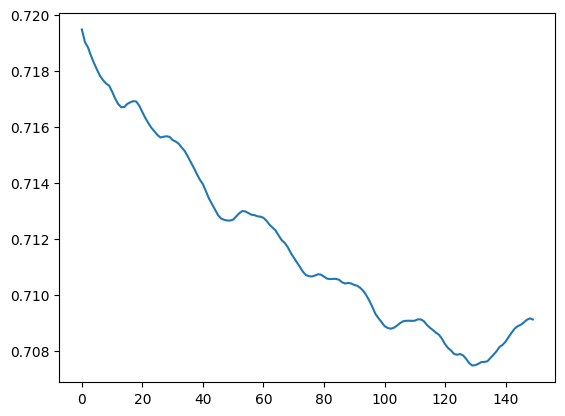

In [13]:
import matplotlib.pyplot as plt

val_loss = out['val_loss']

plt.plot(np.arange(len(val_loss)), val_loss)

In [14]:
metrics = parkinson.utils.train.evaluate(model, test_loader, device)
print('Metrics:', metrics)
print('Done.')

Preds: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]
Metrics: {'acc': 0.6363636363636364, 'f1': 0.5763347763347763, 'recall': 0.6363636363636364, 'precision': 0.5468531468531469}
Done.
